## speeding up wilson's algorithm
if we want to speed up wilson's algorithm, maybe we could construct an oracle that tells us the information we need to simulate wilson's algorithm without actually running full loop-erased random walks. one candidate oracle would be one that, given a target node (or set of nodes) and a starting node, gives us a probability distribution over all paths from start to target that would be yielded by a loop-erased random walk. if we had this oracle, we could run wilson's without actually simulating all of those walks.

**question:** what does that distribution look like for simple examples? setting aside efficiency for now, how could we compute it?

In [123]:
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random

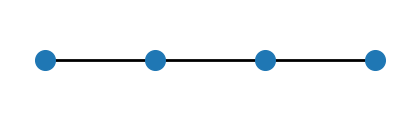

In [2]:
dims = (1,4)
g = tu.generate_grid_graph(dims, queen=False)
tu.draw(g)

what is the probability that a loop-erased random walk goes from the leftmost node to the rightmost node directly? in this case, the probability is 1 — there are no other paths from one end to the other. but if we imagined that we placed two more nodes above the middle two nodes and connected them up to form a square in the middle, we would have two possible paths from left to right. it makes sense that it's more likely that a random walk would go along the bottom path (because it's shorter), but i wonder what the probability distribution would be.

i think an equivalent way to reformulate the question would to be to consider a path graph of length $(n + m + 1)$ where the start node $s$ is $n$ steps away from the left node $l$ and $m$ steps away from the rightmost node $r$, as below:

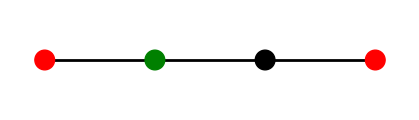

In [14]:
n = 1
m = 2
path_length = n + m + 1
dims = (1, path_length)
node_colors = []
for i in range(path_length):
    if i == 0 or i == path_length - 1:
        color = "red"
    elif i == n:
        color = "green"
    else:
        color = "black"
    node_colors.append(color)
    
g = tu.generate_grid_graph(dims, queen=False)
tu.draw(g, node_colors=node_colors)

here the start node $s$ is colored in green and the ending $l$ and $r$ nodes are both colored in red.

**question:** consider a simple random walk that starts on the green node and terminates once it hits either red node. what is the probability that the random walk will terminate on $l$?

In [29]:
def simulate_walk(n, m):
    state = 0
    while state != -n and state != m:
        if random.random() < 0.5:
            state -= 1
        else:
            state += 1
    return state

In [55]:
num_trials = 1000000
lefts = 0
for _ in tqdm(range(num_trials)):
    state = simulate_walk(1, 2)
    if np.sign(state) < 0:
        lefts += 1

100%|█████████████████████████████| 1000000/1000000 [00:01<00:00, 504245.26it/s]


In [56]:
lefts / num_trials

0.667383

## checking proportions of first LERWs in grid graphs

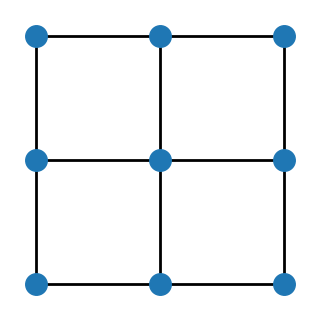

In [294]:
dims = (3,3)
g = tu.generate_grid_graph(dims, queen=False)
# g.remove_node((2,1))
tu.draw(g)

In [280]:
def run_lerw(graph, start, target):
    tree_nodes = set([target])
    next_node = {target: None}
    u = start
    while u not in tree_nodes:
        next_node[u] = random.choice(list(nx.neighbors(graph, u)))
        u = next_node[u]
    u = start
    while u not in tree_nodes:
        tree_nodes.add(u)
        u = next_node[u]

    g = nx.Graph()
    g.add_nodes_from(graph.nodes)
    for node in tree_nodes:
        if next_node[node] is not None:
            g.add_edge(node, next_node[node])
    return g.edges

In [295]:
start = (1,1)
target = (0,1)

all_paths = []
for _ in range(1000):
    path = run_lerw(g, start, target)
    if path not in all_paths:
        all_paths.append(path)
# assert len(all_paths) == 12

def indexer(path):
    return all_paths.index(path)

num_trials = 10000000
path_freqs = {indexer(path): 0 for path in all_paths}
for _ in tqdm(range(num_trials)):
    path = run_lerw(g, start, target)
    path_freqs[indexer(path)] += 1 / num_trials
    
# The below is to resort the partitions by frequency; it's unnecessarily confusing
# resorted_list = sorted([(k, v) for (k, v) in path_freqs.items()], key=lambda x:x[1], reverse=True)

# def reindexer(path):
#     old_index = indexer(path)
#     resorted = [t[0] for t in resorted_list]
#     return resorted.index(old_index)

# path_freqs = {reindexer(path): 0 for path in all_paths}
# num_trials = 10000000
# for _ in tqdm(range(num_trials)):
#     path = run_lerw(g, start, target)
#     path_freqs[reindexer(path)] += 1 / num_trials

100%|████████████████████████████| 10000000/10000000 [09:57<00:00, 16749.16it/s]


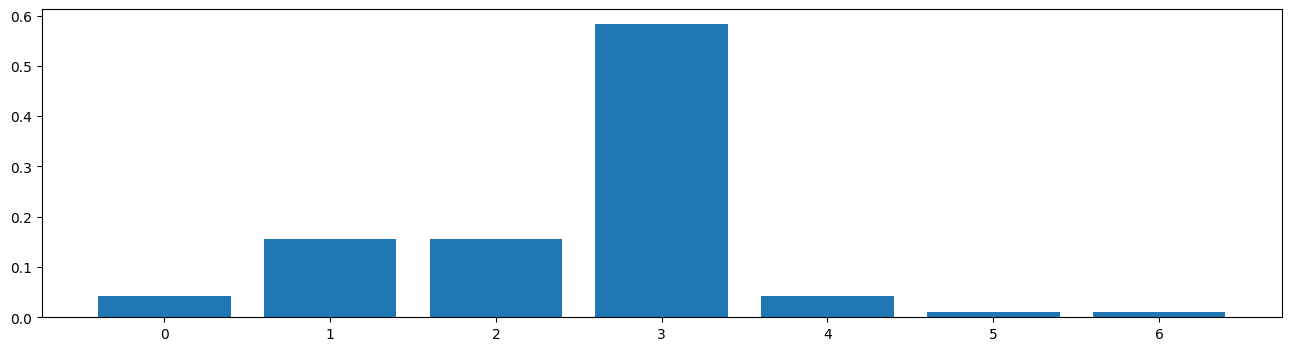

In [296]:
fig, ax = plt.subplots(figsize=(16,4))

_ = plt.bar(x = path_freqs.keys(),
            height = path_freqs.values(),
            # log = True,
           )

In [297]:
path_freqs

{0: 0.04163800000016739,
 1: 0.1563193000034651,
 2: 0.15625730000346333,
 3: 0.5832559999695256,
 4: 0.041707400000169384,
 5: 0.010413699999992417,
 6: 0.01040829999999245}

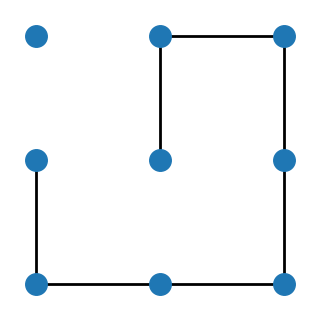

In [303]:
graph = nx.Graph()
graph.add_nodes_from(g.nodes)
graph.add_edges_from(all_paths[5])
tu.draw(graph)